© Jacob White 2025, All Rights Reserved

*Notes taken from Jackel's *Monte Carlo Methods in Finance*. All code is written by me.*

# Stochastic Dynamics: Theory and Practice

## 1. Weiner Processes

A standard Weiner process has the following properties:
1. The expectation of the differential increment $dW_t$ at any one point in time $t$ is zero: $$E[dW_t] = 0 \tag{1}.$$ By **differential increment**, we mean $dW_t = \lim_{\Delta t \to 0} W_{t + \Delta t} - W_t$ for $\Delta t$ a small time increment.
2. The variance of $dW_t$ at any one point in time $t$ is equal to the associated differential increment in time: $$\mathrm{Var}[dW_t] = E[dW_t^2] - (E[dW_t])^2 = E[dW_t^2] = dt.$$ That is, the sum of increments is normally distributed with zero mean and standard deviation $\sqrt{t}$: $$W_t = \int_{s = 0}^t \ dW_s \sim \mathcal{N}(0, \sqrt{t}).$$

In particular, we are interested in the following formula that comes as a result of the second property: $$\boxed{\int_{t = 0}^T f(t) \ dW_t \sim \mathcal{N} \left(0, \sqrt{\int_{t = 0}^T f(t)^2 \ dt}\right)} \tag{$\star$}$$

### 1.1 - Simulating Weiner Processes with Python

For this, we use the `numpy` library for computation and `matplotlib` for visualization.

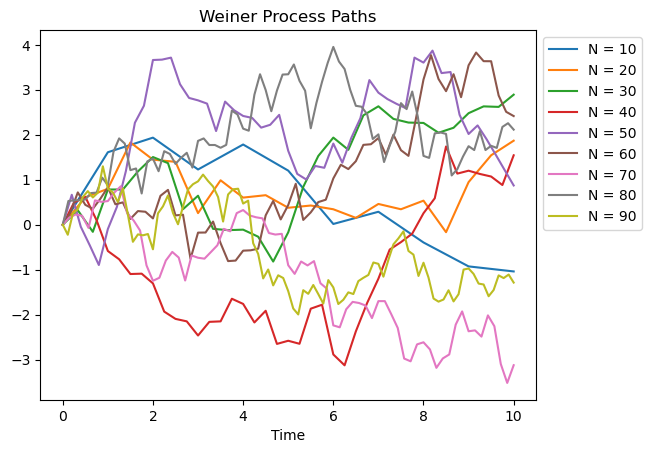

In [152]:
import numpy as np
import matplotlib.pyplot as plt

def weiner(T, N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    increments = np.random.normal(0, np.sqrt(dt), N)
    path = np.cumsum(increments)
    time = np.linspace(0, T, N + 1)
    return time, np.concatenate(([0], path))

T = 10
seed = None

for N in range(10, 100, 10):
    time, path = weiner(T, N, seed)
    plt.plot(time, path, label=f'N = {N}')
plt.title("Weiner Process Paths")
plt.xlabel("Time")
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

### 1.2 - Computing Stochastic Integrals

The goal of this section is to numerically study the equation $(\star)$ above, which we recall here for reference: $$\int_{t = 0}^T f(t) \ dW_t \sim \mathcal{N} \left(0, \sqrt{\int_{t = 0}^T f(t)^2 \ dt}\right).$$

This identity says that $\int_{t = 0}^T f(t) \ dW_t$ follows a normal distribution with mean 0 and variance $||f(t)||_{L^2([0, T])}$. We verify this by sampling the stochastic integral $$I(T) = \int_{t = 0}^T f(t) \ dW_t$$ and seeing if those samples follow a normal distribution. We will use the `weiner` function defined in Section 1.1 above in our computations. We know that $$I := \int_0^T f(t) \ dW_t = \lim_{n \to \infty} \sum_{i = 0}^{n - 1} f(t_i)(W_{t_{i + 1}} - W_{t_i}) \equiv \lim_{n \to \infty} E \left[\left|I - \sum_{i = 0}^{n - 1} f(t_i) (W_{t_{i + 1}} - W_{t_i})\right|^2\right] = 0.$$ for $0 = t_0 < t_1 < \cdots < t_n = T$ a partition of $[0, T]$, and the limit is in the mean square sense.

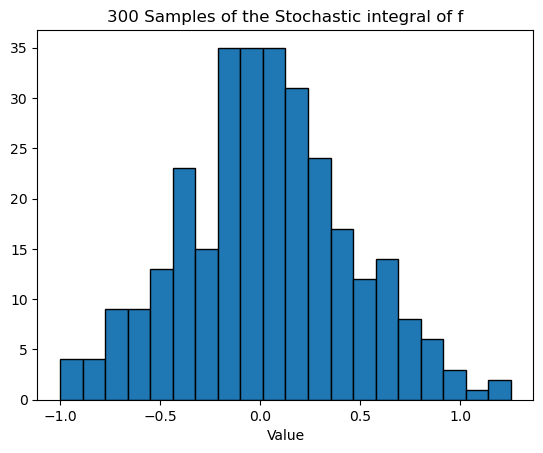

Sample mean: 0.028070552732310468
Standard deviation: 0.42286133871434467


In [161]:
def f(x):
    return x**2

def stochastic_integral(f, T, N, seed = None):
    time, W = weiner(T, N, seed)
    f_t = f(time[:-1]) # The function is evaluated at the left endpoints
    dW = np.diff(W) # nth discrete distance.. i.e., the increments
    stointegral = np.sum(f_t * dW)
    return stointegral

# We're now going to generate a bunch of random samples of the stochastic integral of f

T = 1.0
N = 1000
n_samples = 300
stochastic_samples = []
for i in range(n_samples):
    stochastic_samples.append(stochastic_integral(f, T, N))
    i += 1
stochastic_samples = np.array(stochastic_samples)
# print(stochastic_samples)
plt.hist(stochastic_samples, bins=20, edgecolor='black')
plt.title(f'{n_samples} Samples of the Stochastic integral of f')
plt.xlabel('Value')
plt.show()
print(f'Sample mean: {np.mean(stochastic_samples)}')
print(f'Standard deviation: {np.std(stochastic_samples, ddof = 1)}')


We see from these simulations that our samples produce a mean somewhere around $x = 0$ (which is a good indication). How about the standard deviation, what should we hope to see? We can compute the quantity $$||f||_{L^2([0, 1])} = \sqrt{\int_0^1 (t^2)^2 \ dt} = \sqrt{\frac{1}{5}} \approx 0.447.$$ So far, we are optimistic about seeing $(\star)$ work out in practice. However, we need to make sure that the data we have follows a normal distribution. The `scipy` module gives us many options, such as the Shapiro-Wilk test and the Kolmogorov-Smirnov test. Let's test both:

In [162]:
from scipy import stats

# Shapiro Wilk
stat_sw, p_sw = stats.shapiro(stochastic_samples)
print(f'SW stat: {stat_sw}, SW p-value: {p_sw}') # We want p > 0.05 ideally in order to fail to reject normality

# KS Test
mu, sigma = np.mean(stochastic_samples), np.std(stochastic_samples, ddof = 1)
stat_ks, p_ks = stats.kstest(stochastic_samples, 'norm', args=(mu, sigma))
print(f'KS stat: {stat_ks}, KS p-value: {p_ks}') # We want p > 0.05 ideally in order to fail to reject normality


SW stat: 0.996063322791428, SW p-value: 0.6601594136970044
KS stat: 0.028219734968282506, KS p-value: 0.9652314109352703


Good news: our $p$-values exceed 0.05. I.e., we fail to reject normality vis a vis the Shapiro Wilk and KS tests. So, we have shown in this section what $(\star)$ looks like in practice - sampling from a particular normal distribution is equivalent to sampling values for a given stochastic integral!

## 2. Itô's Lemma

> **Itô's lemma**: The total differential of any function $f(\mathbf{X})$ depending on a stochastic variable $\mathbf{X} \in \mathbb{R}^n$ subject to the system of stochastic differential equations $$dX_i = b_i(t, \mathbf{X}) \ dt + \sum_{k = 1}^n a_{ik}(t, \mathbf{X}) \ dW_{kt}$$ is given by $$df = \left(\sum_{i = 1}^n (\partial_{X_i}f)b_i + \frac{1}{2} \sum_{i, j, k, l = 1}^n (\partial_{X_i X_j}^2 f) a_{ik} \rho_{kl} a_{jl}\right) \ dt + \sum_{i, k = 1}^n (\partial_{X_i} f) a_{ik} \ dW_k$$ where $\rho_{kl} = \frac{E[dW_k dW_l]}{dt}$ is the instantaneous correlation of $dW_{kt}$ and $dW_{lt}$. 

In another form, for $f$ a function of $t$ and $X$, Itô's lemma states that for an *Itô drift-diffusion process* $$dX_t = \mu_t \ dt + \sigma_t \ dW_t$$ and any twice-differentiable scalar function $f(t, x)$ of two real variables $t$ and $x$, one has $$df(t, X_t) = \left(\frac{\partial f}{\partial t} + \mu_t \frac{\partial f}{\partial x} + \frac{\sigma_t^2}{2} \frac{\partial^2 f}{\partial x^2}\right) \ dt + \sigma_t \frac{\partial f}{\partial x} dW_t.$$

### 2.1 - Itô's Lemma and the Black-Scholes Equation

Suppose a stock price follows a geometric Brownian motion given by the stochastic differential equation $$dS = S(\sigma \ dW + \mu \ dt).$$ Then, if the value of an option at time $t$ is $f(t, S_t)$, Itô's lemma gives $$df(t, S_t) = \left(\frac{\partial f}{\partial t} + \mu S_t \frac{\partial f}{\partial S} + \frac{S_t^2\sigma^2}{2} \frac{\partial^2 f}{\partial S^2}\right) \ dt + \sigma S_t \frac{\partial f}{\partial S} \ dW_t.$$ We now construct a portfolio $\Pi = f - \frac{\partial f}{\partial S} S_t$ which has differential $$d\Pi = df - \frac{\partial f}{\partial S} dS_t.$$ Substitute in $df$ and $dS_t$ to obtain $$d\Pi = \left(\frac{\partial f}{\partial t} + \mu S_t \frac{\partial f}{\partial S} + \frac{\sigma^2 S_t^2}{2} \frac{\partial^2 f}{\partial S^2} - \frac{\partial f}{\partial S} \mu S_t\right) \ dt + \left(\sigma S_t \frac{\partial f}{\partial S} - \frac{\partial f}{\partial S} \sigma S_t\right)\ dW_t = \left(\frac{\partial f}{\partial t} + \frac{\sigma^2 S_t^2}{2}\frac{\partial^2 f}{\partial S^2}\right) \ dt.$$ Now, the given portfolio is riskless (no $dW_t$ term), then it earns the risk-free rate $r$. Therefore, $$d\Pi = r\Pi \ dt  r\left(f - \frac{\partial f}{\partial S} S_t\right) \ dt \implies \frac{\partial f}{\partial t} + \frac{\sigma^2 S_t^2}{2} \frac{\partial^2 f}{\partial S^2} = r \left(f - \frac{\partial f}{\partial S} S_t\right).$$ Re-arranging gives the Black-Scholes equation: $$\frac{\partial f}{\partial t} + \frac{\sigma^2 S^2}{2} \frac{\partial^2 f}{\partial S^2} + rS \frac{\partial f}{\partial S} - rf = 0.$$ Boundary conditions are determined by the type of option $f$ is, but this is outside the scope of these notes.

### 2.2 - Numerical Validation of Itô's Lemma

**Notice**: If you have run code above this point, please restart the kernel.

In this section, we numerically validate Itô's lemma for a test function $f(t, x) = x^2$ and a stochastic process $X$ where $$dX_t = \mu X_t \ dt + \sigma X_t \ dW_t$$ for $X_0 = 1$, $\mu = 0.05$,  $\sigma = 0.2$, $T = 1$, and $\Delta t = 0.01$. 
- To simulate $X_t$, we use the **Euler-Maruyama model** where $$\Delta X_t = X_{t + \Delta t} - X_t = \mu X_t \Delta t + \sigma X_t \Delta W_t$$ for $\Delta W_t \sim \mathcal{N}(0, \Delta t)$. 

Let's start by simulating the process $f(X)$ and graphing it.

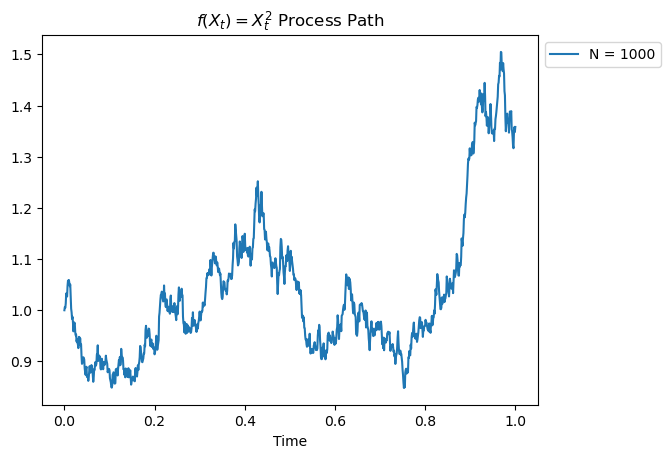

In [77]:
# Itô's lemma numerical validation script
import numpy as np
import matplotlib.pyplot as plt

# Weiner process definition from above
def weiner(T, N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    increments = np.random.normal(0, np.sqrt(dt), N)
    path = np.cumsum(increments)
    time = np.linspace(0, T, N + 1)
    return time, np.concatenate(([0], path))
def f(x):
    return x**2
def fp(x):
    return 2*x
def fpp(x):
    return 2
def ft(x):
    return 0
    
T = 1
N = 1000 # T/N = Δt = 0.01 
mu = 0.05 # ALT+230
sigma = 0.2 # ALT+229
X0 = 1.0
n_paths = 100

# Simulate the stochastic process X
def simX(T, N, mu, sigma, X0, seed=None):
    dt = T / N
    time, W = weiner(T, N, seed)
    X = np.zeros(N + 1)
    X[0] = X0

    #Below is the Euler-Maruyama Method
    for i in range(N):
        X[i + 1] = X[i] + mu * X[i] * dt + sigma * X[i] * (W[i + 1] - W[i])
    return time, X, W  

# If you want to plot the process f(X), if you want to plot just X, replace "f(path)" in the second line with just "path"
time, path, _ = simX(T, N, mu, sigma, X0, 42)
plt.plot(time, f(path), label=f'N = {N}')
plt.title("$f(X_t) = X_t^2$ Process Path")
plt.xlabel("Time")
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

Now, we'll validate Itô's lemma by computing the numerical change in $f$: $$df \approx \Delta f = f(X_{t + \Delta t}) - f(X_t)$$ with the equation from Itô's lemma: $$df \approx \frac{\partial f}{\partial t} + \mu X \frac{\partial f}{\partial X} + \frac{\sigma^2 X^2}{2} \frac{\partial^2 f}{\partial X^2} \Delta t + \sigma X \frac{\partial f}{\partial X} \Delta W$$

In [78]:
def itoValidation(T, N, mu, sigma, X0, n_paths, seed=None):
    dt = T / N
    np.random.seed(seed)
    num_df = []
    ito_df = []
    for _ in range(n_paths):
        time, X, W = simX(T, N, mu, sigma, X0)
        for i in range(N):
            delta_f = f(X[i + 1]) - f(X[i])
            num_df.append(delta_f)
            dW = W[i + 1] - W[i]
            ito_eval = (ft(X[i]) + mu * X[i] * fp(X[i]) + (sigma**2 * X[i]**2 / 2) * fpp(X[i])) * dt + sigma * X[i] * fp(X[i]) * dW
            ito_df.append(ito_eval)
    return np.array(num_df), np.array(ito_df)

num_df, ito_df = itoValidation(T, N, mu, sigma, X0, n_paths, seed=42)
mse = np.mean((num_df - ito_df)**2)
print(f'Mean squared error: {mse}')

Mean squared error: 3.998890390186911e-09


This code takes a very long time to run (~2000 seconds!) for 
```
T = 1
N = 1000 # T/N = Δt = 0.01 
mu = 0.05 # ALT+230
sigma = 0.2 # ALT+229
X0 = 1.0
n_paths = 10000
```

We attempt a CUDA speedup in `stochastic_dynamics_CUDA.ipynb`.

**Anyway, all of this programming aside, we do see that we can experimentally validate Itô's formula by running numerical simulations.**

### 2.3 - Normal Processes